#  Self-tuning random forests

A demonstration of ensembling and tuning in MLJ

In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


In [2]:
using MLJ
using Plots
pyplot()

Plots.PyPlotBackend()

Load a task (data plus learning objective):

In [3]:
task = load_boston()

SupervisedTask{} @ 1…73


To see how to construct your own task, see [Working with Tasks](https://alan-turing-institute.github.io/MLJ.jl/dev/working_with_tasks/)

Which models are available for the present task?

In [4]:
models(task)

Dict{String,Any} with 6 entries:
  "MultivariateStats" => Any["RidgeRegressor"]
  "MLJ"               => Any["KNNRegressor", "RidgeRegressor"]
  "DecisionTree"      => Any["DecisionTreeRegressor"]
  "ScikitLearn"       => Any["ElasticNet", "ElasticNetCV", "SVMRegressor", "SVM…
  "LIBSVM"            => Any["EpsilonSVR", "NuSVR"]
  "XGBoost"           => Any["XGBoostRegressor"]

## Evaluating a single decision tree

In [5]:
@load DecisionTreeRegressor

import MLJModels ✔
import DecisionTree ✔
import MLJModels.DecisionTree_.DecisionTreeRegressor ✔


In [6]:
tree = DecisionTreeRegressor()
mach = machine(tree, task)
evaluate!(mach, resampling=Holdout(fraction_train=0.8), measure=[rms,rmslp1])

┌ Info: Evaluating using a holdout set. 
│ fraction_train=0.8 
│ shuffle=false 
│ measure=Function[rms, rmslp1] 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/anthony/.julia/packages/MLJ/w0rRg/src/resampling.jl:91


(MLJ.rms = 7.054322052311654,
 MLJ.rmslp1 = 0.32730942581047084,)

## Creating a random forest by ensembling

In [7]:
forest = EnsembleModel(atom=tree)

MLJ.DeterministicEnsembleModel(atom = DecisionTreeRegressor{} @ 1…78,
                               weights = Float64[],
                               bagging_fraction = 0.8,
                               rng = MersenneTwister(UInt32[0xfebac82e, 0xbb0da0c7, 0x81f5768f, 0x667de56c]),
                               n = 100,
                               parallel = true,
                               out_of_bag_measure = Any[],) @ 5…59

In [8]:
@more

MLJ.DeterministicEnsembleModel(atom = DecisionTreeRegressor(pruning_purity_threshold = 0.0,
                                                            max_depth = -1,
                                                            min_samples_leaf = 5,
                                                            min_samples_split = 2,
                                                            min_purity_increase = 0.0,
                                                            n_subfeatures = 0,
                                                            post_prune = false,),
                               weights = Float64[],
                               bagging_fraction = 0.8,
                               rng = MersenneTwister(UInt32[0xfebac82e, 0xbb0da0c7, 0x81f5768f, 0x667de56c]),
                               n = 100,
                               parallel = true,
                               out_of_bag_measure = Any[],) @ 5…59

We start by reducing number of features sampled at each tree node. We will use the square root of the
number of features, a common default:

In [9]:
tree.n_subfeatures = 3;

To get an idea of how many trees we need, we wrap our forest model in the task, pick a range for the ensemeble size, `n`, and generate learning curves (plots of model performance against `n`):

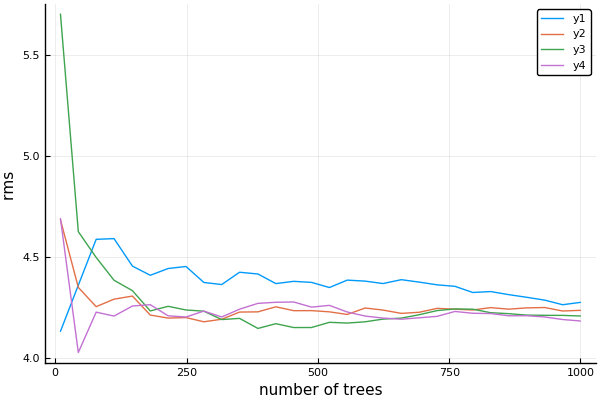

In [10]:
mach = machine(forest, task)
r = range(forest, :n, lower=10, upper=1000)
curves = learning_curve!(mach,
    resampling=Holdout(fraction_train=0.8),
    nested_range=(n=r,), 
    measure=rms, n=4,
    verbosity=0)
plot(curves.parameter_values, curves.measurements,
     xlab="number of trees", ylab="rms ")

In [11]:
savefig("learningcurves.png")

In [12]:
forest.n = 300;

# Tuning

As `forest` is a composite model, it has nested hyperparameters:

In [13]:
params(forest) # all hyperparameters, as a named tuple

(atom = (pruning_purity_threshold = 0.0,
         max_depth = -1,
         min_samples_leaf = 5,
         min_samples_split = 2,
         min_purity_increase = 0.0,
         n_subfeatures = 3,
         post_prune = false,),
 weights = Float64[],
 bagging_fraction = 0.8,
 rng = MersenneTwister(UInt32[0xfebac82e, 0xbb0da0c7, 0x81f5768f, 0x667de56c]),
 n = 300,
 parallel = true,
 out_of_bag_measure = Any[],)

Let's define ranges for two hyperparameters we want to tune:

In [14]:
r1 = range(tree, :n_subfeatures, lower=1, upper=12)
r2 = range(forest, :bagging_fraction, lower=0.4, upper=1.0);

We collate the ranges using by matching the pattern of `params(forest)` above, omitting parameters that don't change:

In [15]:
nested_ranges = (atom=(n_subfeatures=r1,), 
                 bagging_fraction=r2)

(atom = (n_subfeatures = NumericRange{n_subfeatures} @ 5…22,),
 bagging_fraction = NumericRange{bagging_fraction} @ 5…68,)

We now wrap our forest in tuning strategy to obtain a new "self-tuning" model!

In [16]:
tuned_forest = TunedModel(model=forest, 
                          tuning=Grid(resolution=12),
                          resampling=CV(nfolds=6),
                          nested_ranges=nested_ranges, 
                          measure=rms)

MLJ.DeterministicTunedModel(model = DeterministicEnsembleModel{DecisionTreeRegressor} @ 5…59,
                            tuning = Grid{} @ 7…02,
                            resampling = CV{} @ 2…13,
                            measure = MLJ.rms,
                            operation = StatsBase.predict,
                            nested_ranges = (atom = (n_subfeatures = NumericRange{n_subfeatures} @ 5…22,), bagging_fraction = NumericRange{bagging_fraction} @ 5…68),
                            minimize = true,
                            full_report = true,) @ 1…23

In [17]:
params(tuned_forest)

(model = (atom = (pruning_purity_threshold = 0.0,
                  max_depth = -1,
                  min_samples_leaf = 5,
                  min_samples_split = 2,
                  min_purity_increase = 0.0,
                  n_subfeatures = 3,
                  post_prune = false,),
          weights = Float64[],
          bagging_fraction = 0.8,
          rng = MersenneTwister(UInt32[0xfebac82e, 0xbb0da0c7, 0x81f5768f, 0x667de56c]),
          n = 300,
          parallel = true,
          out_of_bag_measure = Any[],),
 tuning = (resolution = 12,
           parallel = true,),
 resampling = (nfolds = 6,
               parallel = true,
               shuffle = false,),
 measure = MLJ.rms,
 operation = StatsBase.predict,
 nested_ranges = (atom = (n_subfeatures = NumericRange{n_subfeatures} @ 5…22,),
                  bagging_fraction = NumericRange{bagging_fraction} @ 5…68,),
 minimize = true,
 full_report = true,)

## Evaluating the self-tuning random forest 

We evaluate our self-tuning random forest the same as any other model:

In [ ]:
mach = machine(tuned_forest, task)
evaluate!(mach, resampling=Holdout(fraction_train=0.8), measure=[rms, rmslp1])

Implicit in this evaluation is nested resampling: `evaluate!` fits `tuned_forest` on the training data and evaluates its performance on the 20% holdout test set. On the other hand, fitting `tuned_forest` means:
(i) searching over all parameters specified by `nested_ranges` above for the values optimizing performance, as estimated by cross-validation on the supplied data (80% of all data); and (ii)
and retraining a `forest` on all of that supplied data, using the optimal parameters.

We can view the optimal `forest` hyperparameters:

In [ ]:
fitted_params(mach)

In [ ]:
best = fitted_params(mach).best_model
@show best.bagging_fraction
@show best.atom.n_subfeatures;

And plot the performance estimates for the grid search:

In [ ]:
plot(mach)